In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Uncomment the follwing line to enabled devlib debugging statements
#logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.10',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched:*",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

04:02:50  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
04:02:50  INFO    : %14s - Loading custom (inline) target configuration
04:02:50  INFO    :         Target - Connecing linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
04:03:28  INFO    :         Target - Initializing target workdir [/root/devlib-target]
04:03:31  INFO    : Target topology: [[0, 3, 4, 5], [1, 2]]
04:03:34  INFO    :         FTrace - Enabled events:
04:03:34  INFO    :         FTrace -   ['sched:*', 'cpu_frequency', 'cpu_capacity']
04:03:34  INFO    :    EnergyMeter - Channels selected for energy sampling:
[CHAN(v2m_juno_energy/energy1, a57_energy), CHAN(v2m_juno_energy/energy1, a53_energy)]
06:00:19  INFO    : Loading RTApp calibration from configuration file...
06:00:19  INFO    : Using RT-App calibration values: {0: 361, 1: 138, 2: 138, 3: 352, 4: 360, 5: 353}


In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

06:00:19  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


# Support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
    'ondemand' : {
        'label' : 'odm',
        'set' :  set_ondemand,
    }
}

# The set of results forlder for each comparition test
results = {}

In [8]:
def experiment(governor, rtapp, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    # Start FTrace and Energy monitoring
    te.ftrace.start()
    te.emeter.reset()
    
    # Run the workload
    rtapp.run(out_dir=exp_dir)
    
    # Stop FTrace and sample Energy consumption
    nrg = te.emeter.sample()
    te.ftrace.stop()
    
    logging.info('Energy: %s', nrg)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(te.platform, exp_dir)
    ta = TraceAnalysis(tr, te.platform)
    
    # return all the experiment data
    return {
        'dir'      : exp_dir,
        'energy'   : nrg,
        'trace'    : trace_file,
        'run'      : tr.run,
        'ta'       : ta
    }

    
def compare(tid, rtapp):    
    logging.info('Test case: %s', tid)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        test_dir = os.path.join(res_dir, governor)
        res = experiment(governor, rtapp, test_dir)
        results[tid][governor] = copy.deepcopy(res)
        
def plot(tid):
    global results
    
    templates = [trappy.sched.SchedLoadAvgCpu, trappy.sched.SchedCpuCapacity]
    column = ["util_avg", "state"]
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['run'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
        
    for governor in confs:
        pa = PerfAnalysis(results[tid][governor]['dir'])
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
        
def report_nrg(tid):
    global results
    
    print "{:15s} | {:>9s} {:>9s} {:>9s}"\
        .format('Governor', 'A53', 'A57', 'Total')
    print "{:-<16s}+{:-<30s}".format('', '')
    for governor in confs:
        plot_title = "{}".format(governor.upper())
        nrg = results[tid][governor]['energy']
        nrg_little = float(nrg['a53']['delta'])
        nrg_big = float(nrg['a57']['delta'])
        nrg_sum = nrg_little + nrg_big
        print "{:15s} | {:9.3f} {:9.3f} {:9.3f}"\
            .format(governor, nrg_little, nrg_big, nrg_sum)

# Test: light/heavy/light

In [9]:
# Define a label for this test case
test_case = 'light-heavy-light'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   10)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

06:00:20  ERROR   : Assuming taskset is preinstalled
06:00:20  INFO    : Setup new workload smoke
06:00:21  INFO    : Workload duration defined by longest task
06:00:21  INFO    : Default policy: SCHED_OTHER
06:00:21  INFO    : ------------------------
06:00:21  INFO    : task [task1], sched: using default policy
06:00:21  INFO    :  | loops count: 1
06:00:21  INFO    :  | CPUs affinity: 1
06:00:21  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
06:00:21  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:00:21  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
06:00:21  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
06:00:21  INFO    :  |  period   100000 [us], duty_cycle  90 %
06:00:21  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
06:00:21  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
06:00:21  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:00:21  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]


In [10]:
# Run this workload in all the configurations
compare(test_case, rtapp)

06:00:21  INFO    : Test case: light-heavy-light
06:00:21  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151116_180019/light-heavy-light
06:00:21  INFO    : ------------------------
06:00:21  INFO    : Run workload using performance governor
06:00:28  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:00:30  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:00:32  INFO    : Energy: {'a53': {'total': 0.7722579999999653, 'last': 1264.51197, 'delta': 0.7722579999999653}, 'a57': {'total': 4.383304999999837, 'last': 1991.42879, 'delta': 4.383304999999837}}
06:00:37  INFO    : Collected events spans a 5.828 [s] time interval
06:00:37  INFO    : Set plots time range to (0.000000, 5.828401)[s]
06:00:37  INFO    : ------------------------
06:00:37  INFO    : Run workload using sched governor
06:00:45  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_

In [11]:
# Plot all data collected from experiments
def plot(tid):
    global results
    
    # Plot CPU LoadAvg and Capacity (for CPU0)
    templates = [trappy.sched.SchedLoadAvgCpu, trappy.sched.SchedCpuCapacity]
    column = ["util_avg", "capacity"]
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['run'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        ta = results[tid][governor]['ta']
        logging.info("%s:", plot_title)
        ta.plotClusterFrequencies(title=plot_title)
    
    # Plot RTApp performance index
    for governor in confs:
        plot_title = "RTApp performances, {}".format(governor.upper())
        pa = PerfAnalysis(results[tid][governor]['dir'])
        logging.info("%s:", plot_title)
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
            

/home/derkling/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
06:01:23  INFO    : Cluster frequencies, PERFORMANCE:
06:01:23  INFO    : LITTLE cluster average frequency: 0.850 GHz
06:01:23  INFO    : big    cluster average frequency: 1.100 GHz
06:01:23  INFO    : Cluster frequencies, SCHED:
06:01:23  INFO    : LITTLE cluster average frequency: 0.474 GHz
06:01:23  INFO    : big    cluster average frequency: 0.486 GHz
06:01:23  INFO    : Cluster frequencies, ONDEMAND:
06:01:24  INFO    : LITTLE cluster average frequency: 0.460 GHz
06:01:24  INFO    : big    cluster average frequency: 0.580 GHz
06:01:24  INFO    : RTApp performances, PERFORMANCE:
06:01:24  INFO    : PerfIndex, Task [task1] avg: 0.95, std: 0.01
06:01:24  INFO    : RTApp performances, SCHED:
06:01:24  INFO    : PerfIndex, Task [task1] avg: 0.71, std: 0.45
06:01

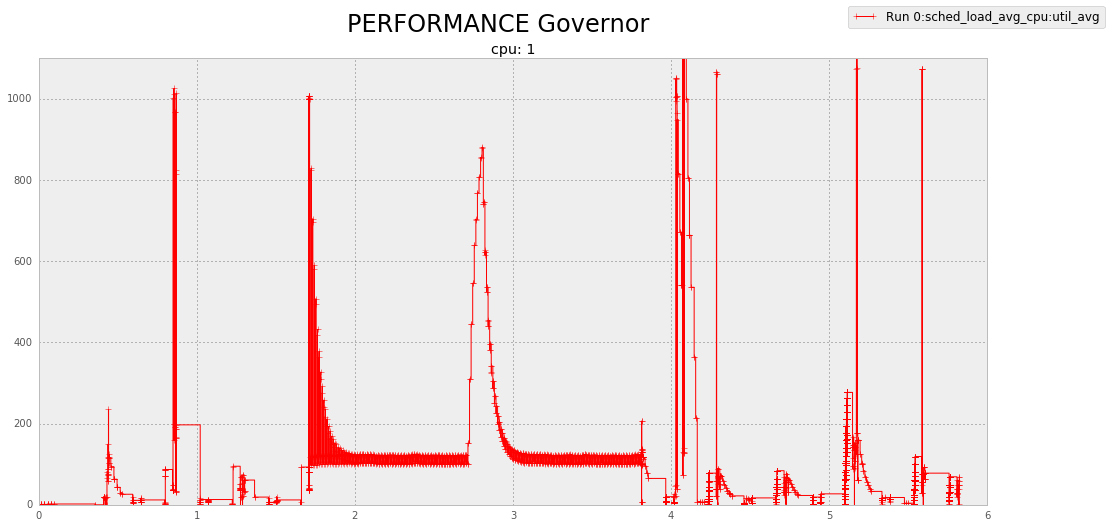

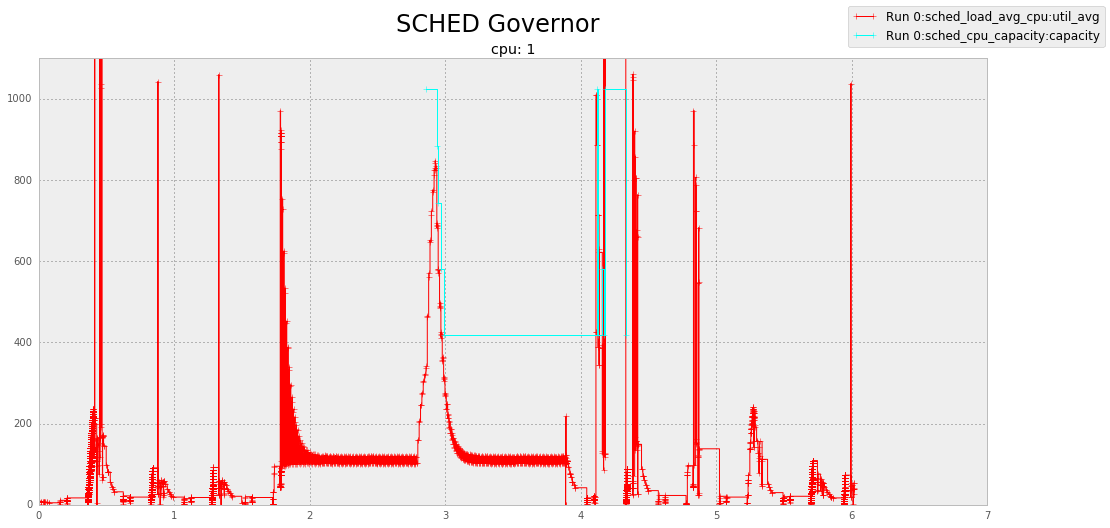

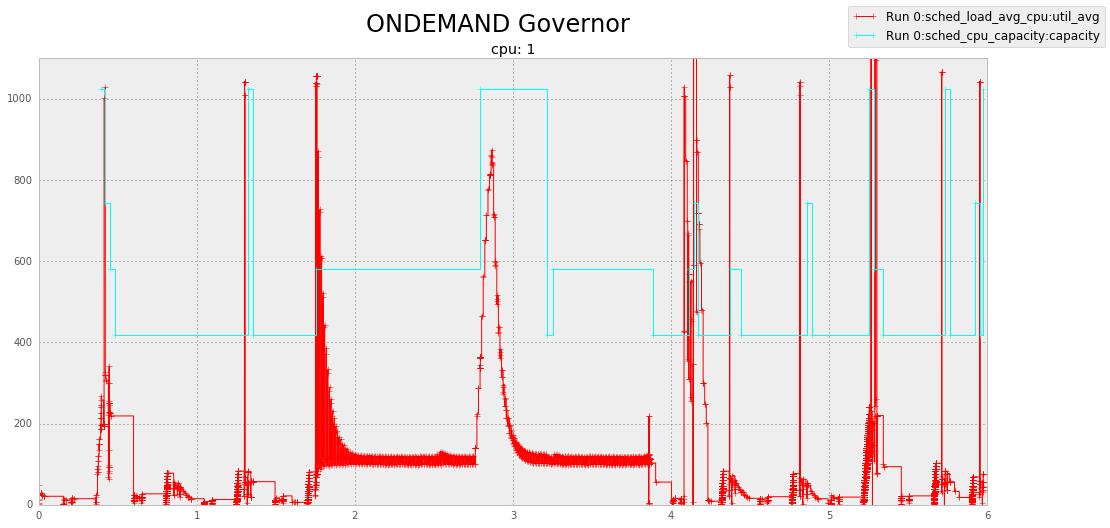

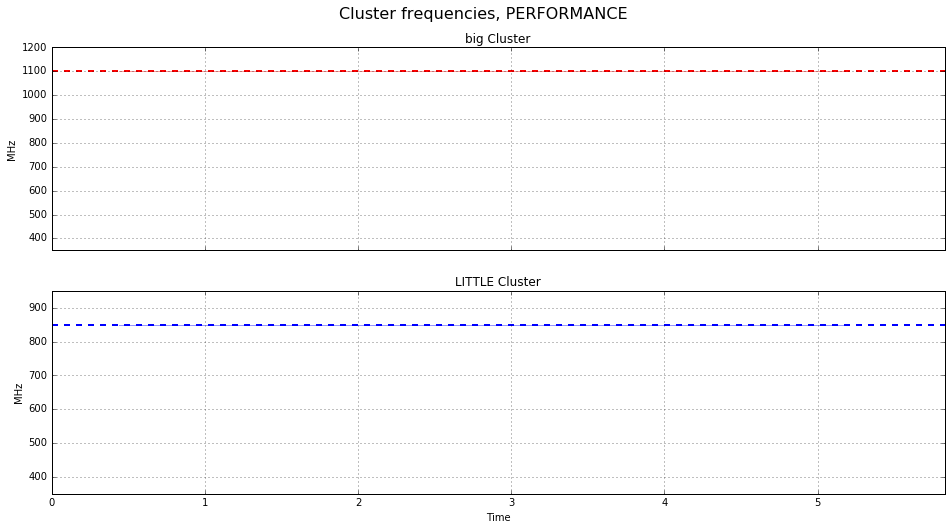

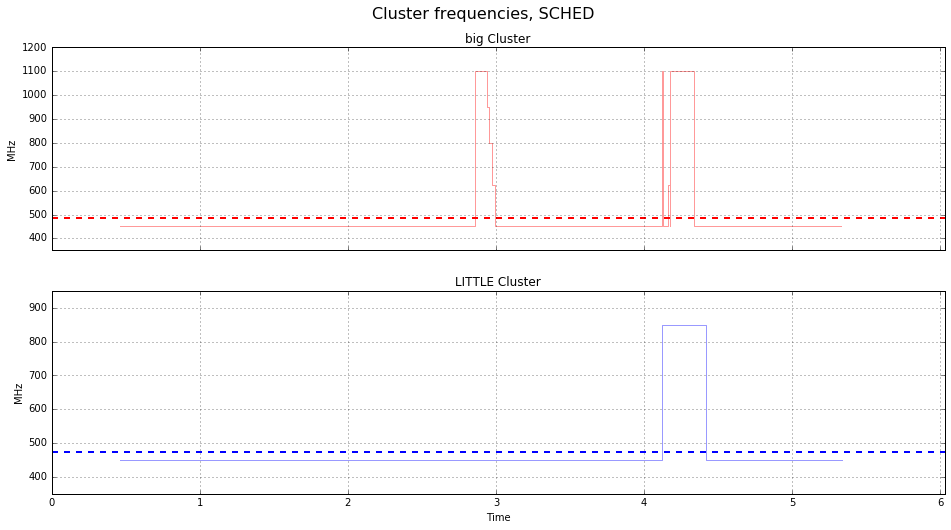

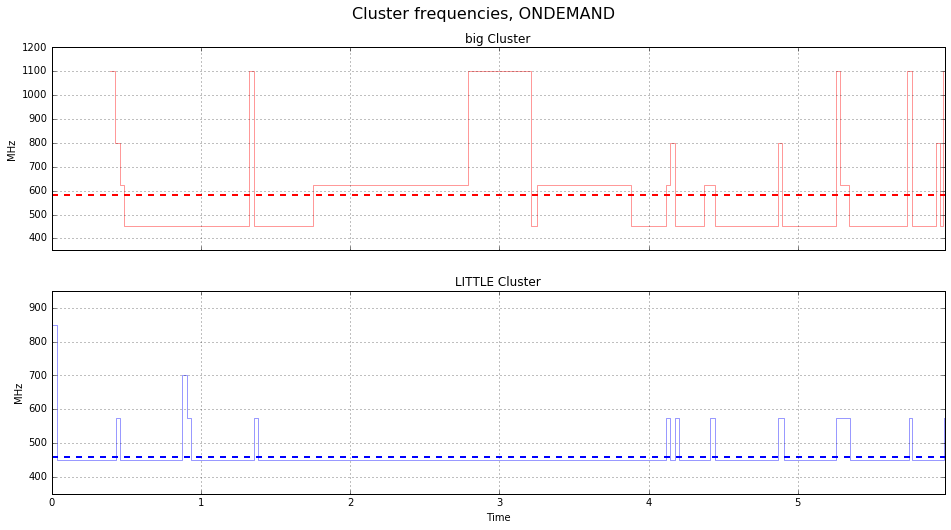

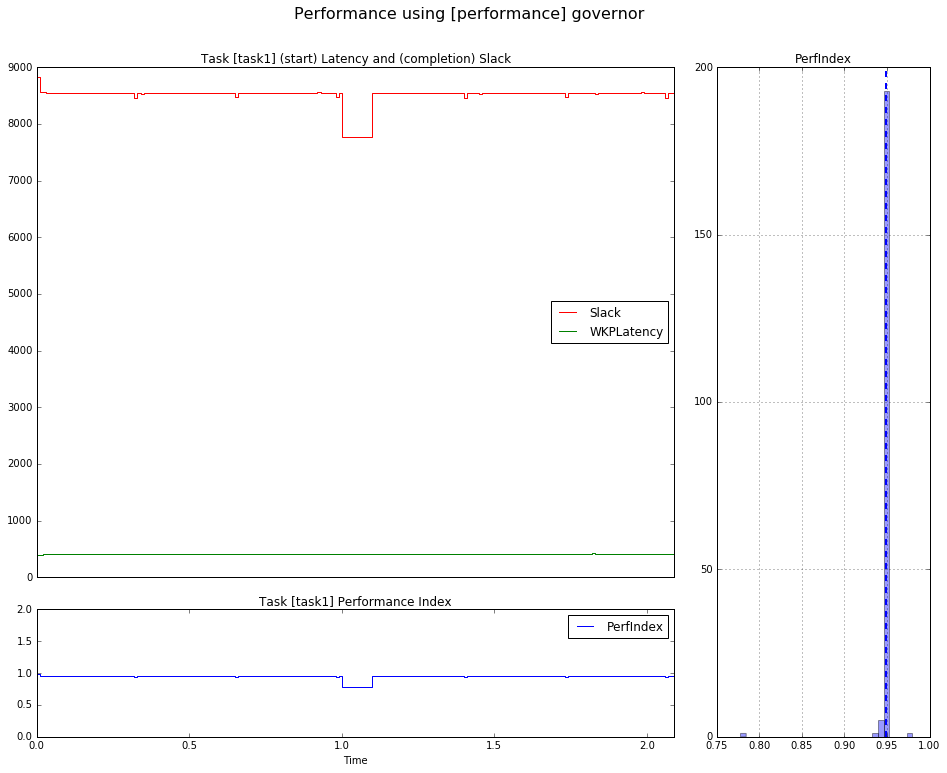

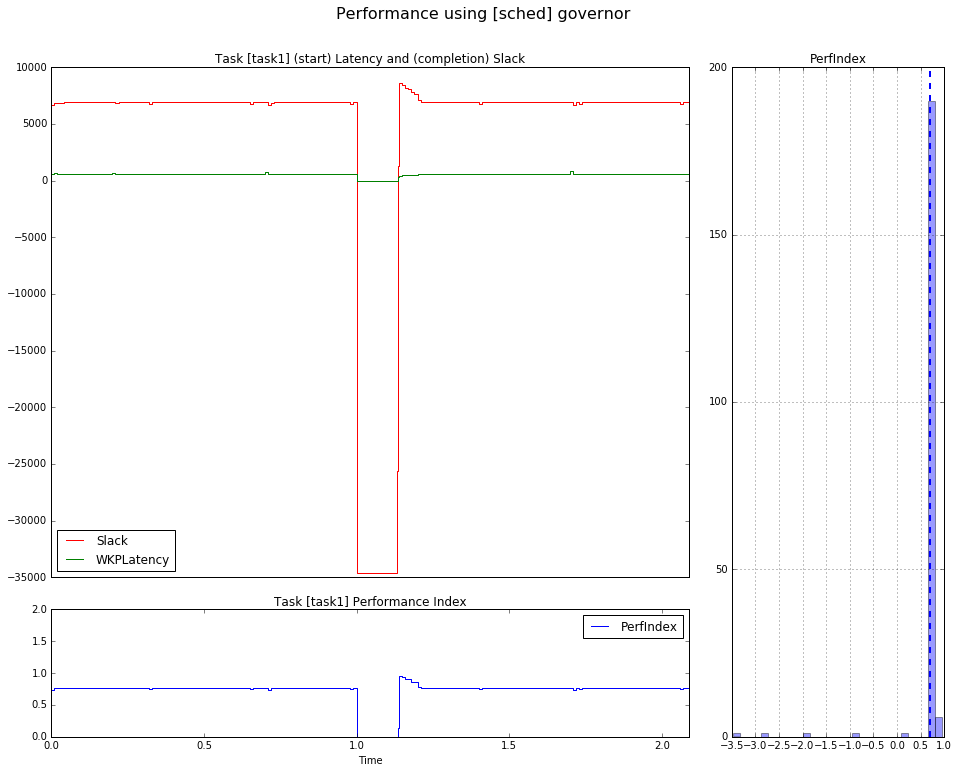

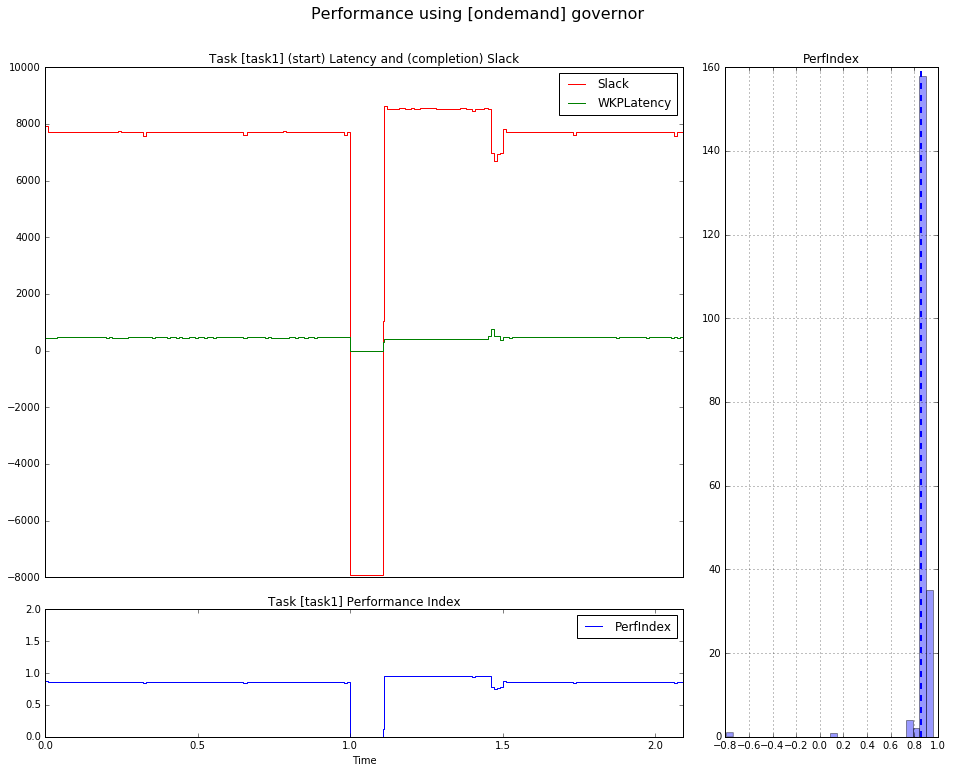

In [12]:
plot(test_case)

In [13]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.772     4.383     5.156
sched           |     0.553     3.129     3.681
ondemand        |     0.493     3.380     3.873


# Test: light/heavy/medium

In [14]:
# Define a label for this test case
test_case = 'light-heavy-medium'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   50)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

06:01:27  ERROR   : Assuming taskset is preinstalled
06:01:27  INFO    : Setup new workload smoke
06:01:27  INFO    : Workload duration defined by longest task
06:01:27  INFO    : Default policy: SCHED_OTHER
06:01:27  INFO    : ------------------------
06:01:27  INFO    : task [task1], sched: using default policy
06:01:27  INFO    :  | loops count: 1
06:01:27  INFO    :  | CPUs affinity: 1
06:01:27  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
06:01:27  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:01:27  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
06:01:27  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
06:01:27  INFO    :  |  period   100000 [us], duty_cycle  90 %
06:01:27  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
06:01:27  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
06:01:27  INFO    :  |  period    10000 [us], duty_cycle  50 %
06:01:27  INFO    :  |  run_time   5000 [us], sleep_time   5000 [us]


In [15]:
# Run this workload in all the configurations
compare(test_case, rtapp)

06:01:27  INFO    : Test case: light-heavy-medium
06:01:27  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151116_180019/light-heavy-medium
06:01:27  INFO    : ------------------------
06:01:27  INFO    : Run workload using performance governor
06:01:35  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:01:37  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:01:39  INFO    : Energy: {'a53': {'total': 0.8031909999999698, 'last': 1280.728225, 'delta': 0.8031909999999698}, 'a57': {'total': 7.2549320000000534, 'last': 2045.882951, 'delta': 7.2549320000000534}}
06:01:44  INFO    : Collected events spans a 5.849 [s] time interval
06:01:44  INFO    : Set plots time range to (0.000000, 5.849197)[s]
06:01:44  INFO    : ------------------------
06:01:44  INFO    : Run workload using sched governor
06:01:51  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/

06:02:29  INFO    : Cluster frequencies, PERFORMANCE:
06:02:30  INFO    : LITTLE cluster average frequency: 0.850 GHz
06:02:30  INFO    : big    cluster average frequency: 1.100 GHz
06:02:30  INFO    : Cluster frequencies, SCHED:
06:02:30  INFO    : LITTLE cluster average frequency: 0.457 GHz
06:02:30  INFO    : big    cluster average frequency: 0.561 GHz
06:02:30  INFO    : Cluster frequencies, ONDEMAND:
06:02:30  INFO    : LITTLE cluster average frequency: 0.463 GHz
06:02:30  INFO    : big    cluster average frequency: 0.618 GHz
06:02:30  INFO    : RTApp performances, PERFORMANCE:
06:02:30  INFO    : PerfIndex, Task [task1] avg: 0.92, std: 0.03
06:02:30  INFO    : RTApp performances, SCHED:
06:02:30  INFO    : PerfIndex, Task [task1] avg: 0.48, std: 0.93
06:02:31  INFO    : RTApp performances, ONDEMAND:
06:02:31  INFO    : PerfIndex, Task [task1] avg: 0.78, std: 0.17


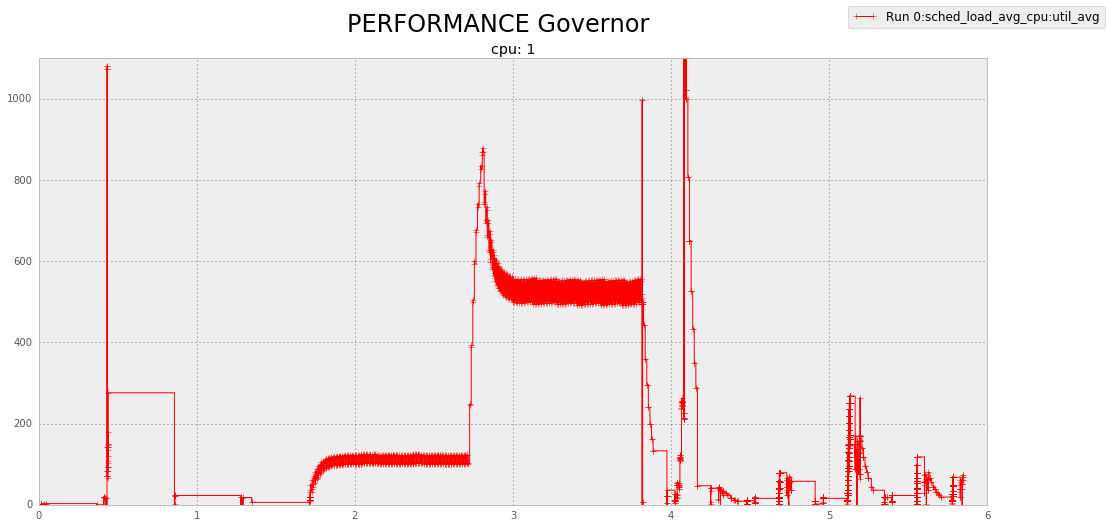

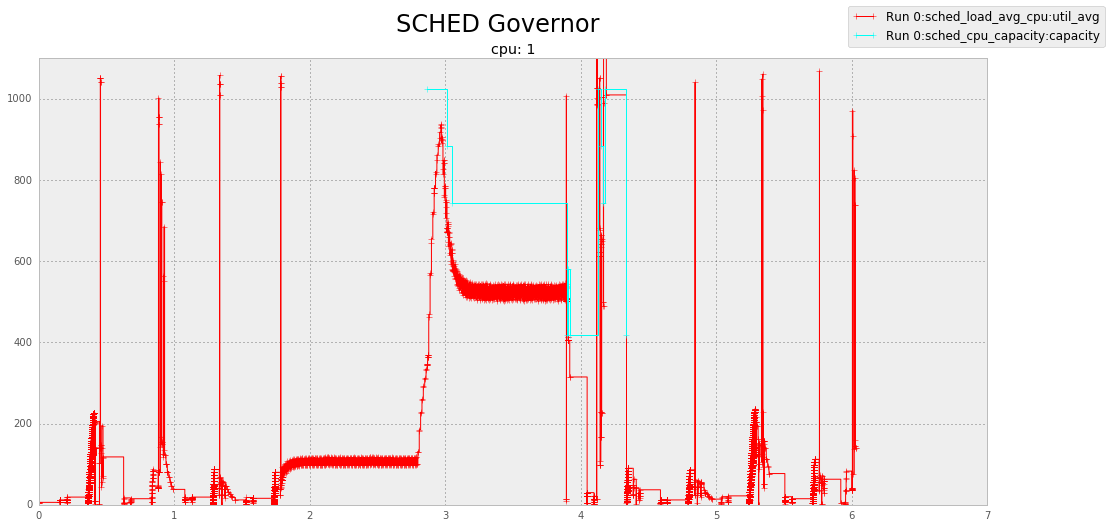

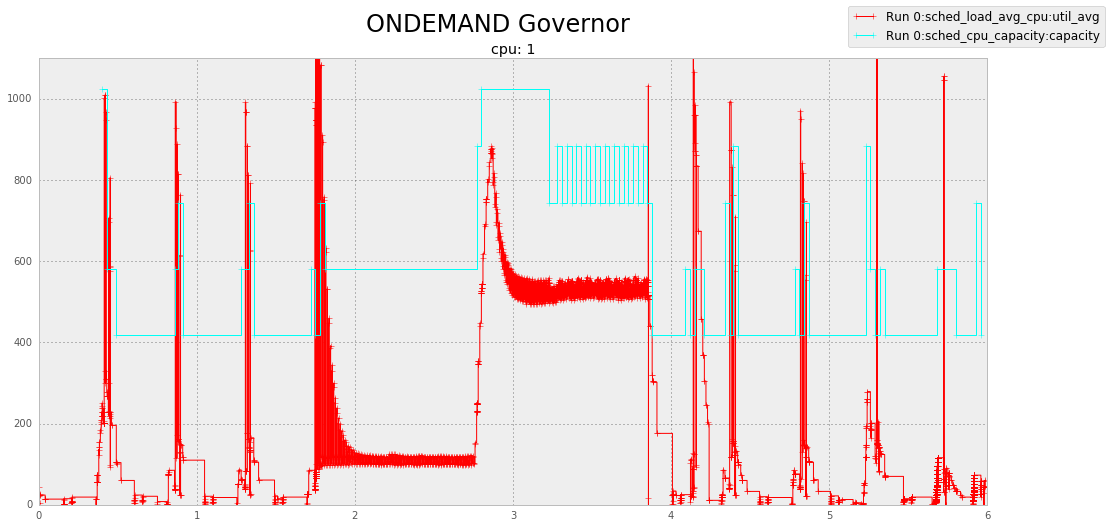

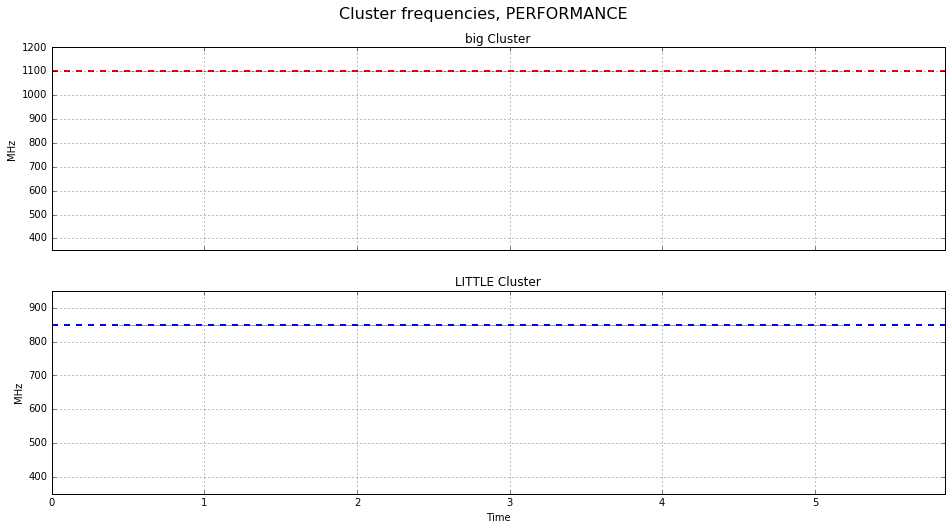

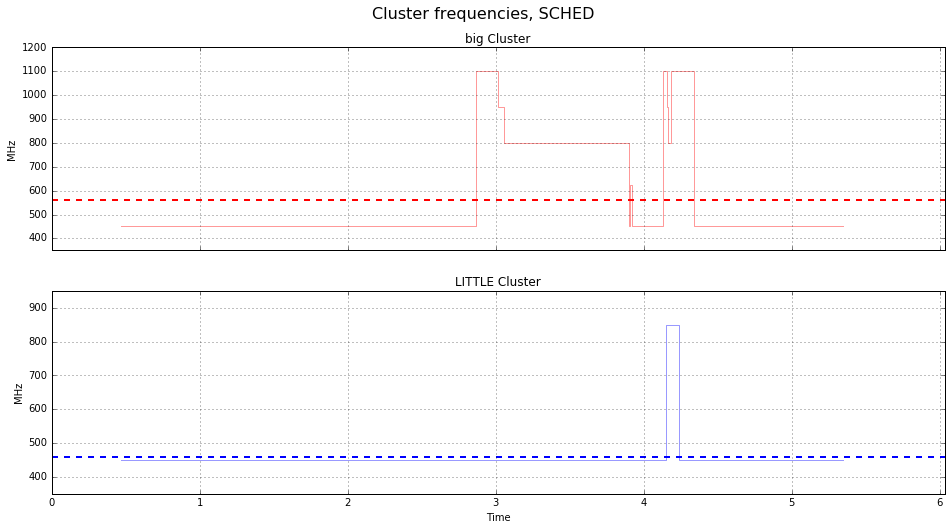

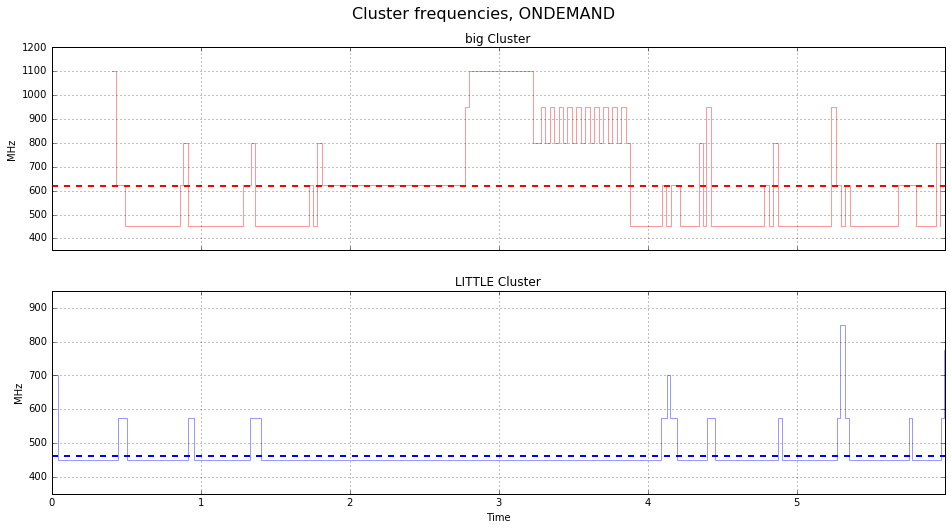

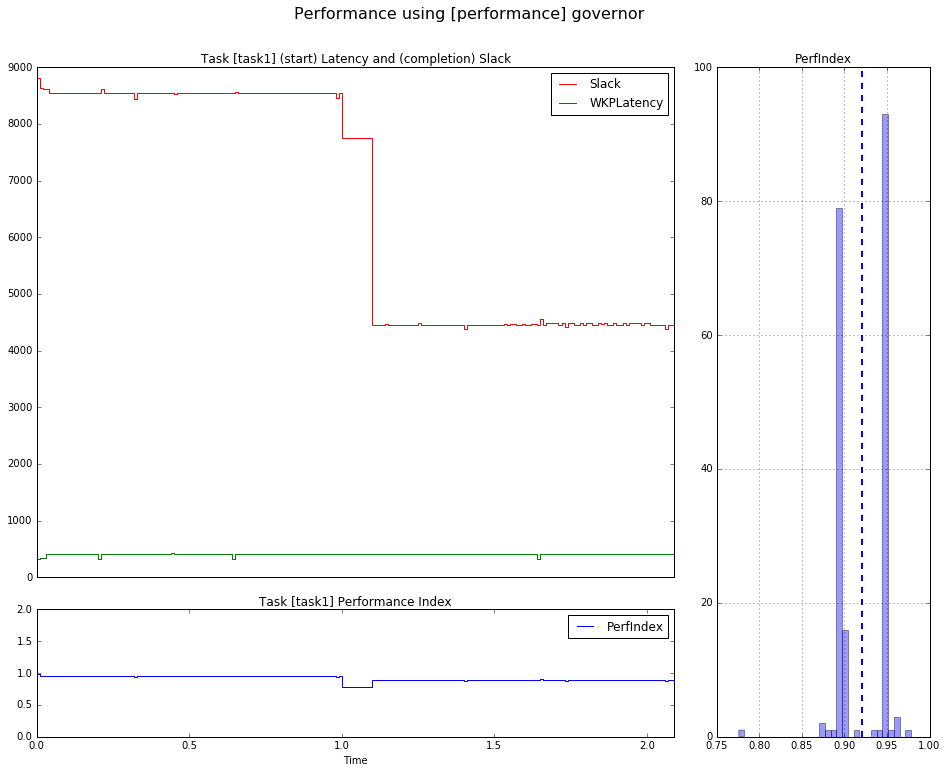

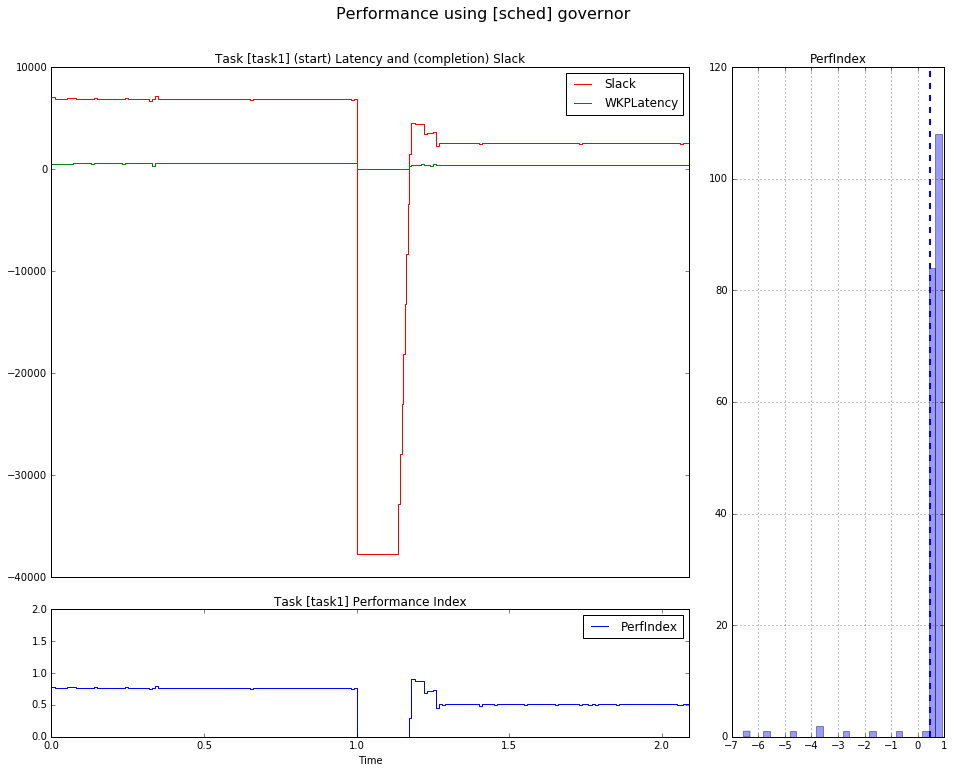

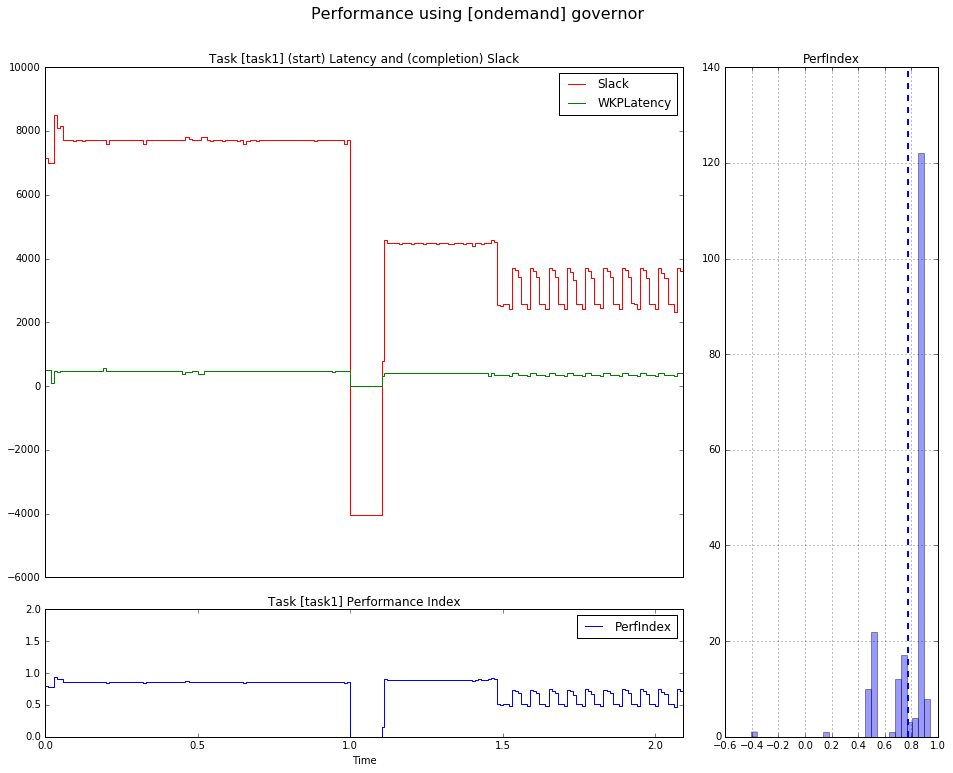

In [16]:
plot(test_case)

In [17]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.803     7.255     8.058
sched           |     0.497     6.005     6.502
ondemand        |     0.514     6.457     6.971
